In [1]:
import os
import torch
from PIL import Image
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import numpy as np
from skimage import io, transform
import matplotlib.pyplot as plt
import time
plt.ion()

In [2]:
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    print("MPS found")
    device = torch.device("mps")

MPS found


In [3]:
train_folder_path = './data/FER2013Train'
test_folder_path = './data/FER2013Test'
public_test_folder_path = '/data/FER2013Valid'

In [4]:
class FERPlusDataset(Dataset):
    """FERPlus dataset."""
    
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.img_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_frame)

#     to access elements using the [] 
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

#             to make the image name 
        img_name = os.path.join(self.root_dir,
                                self.img_frame.iloc[idx, 0])
    
        image = io.imread(img_name)
        #dimensions = self.img_frameiloc[n, 1]
        emotions = self.img_frame.iloc[idx, 2:]
#         print("emo1: ", emotions)
        emotions = np.asarray(emotions)
#         print("emo2: ", emotions)
        
        emotions = emotions.astype('float32')
#         print("emo3: ", emotions)
        
        sample = {'image': image, 'emotions': emotions}
#         print("sample: ", sample)
        if self.transform:
            sample = self.transform(sample)

        return sample
    

#     class to transform to tensor
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, emotions = sample['image'], sample['emotions']
        transform = transforms.ToTensor()
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        #image = image.transpose(1,0)
        return {'image': transform(image),
                'emotions': emotions}

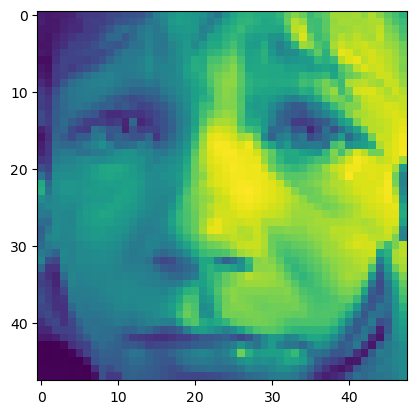

In [5]:
batch_size = 10 #how many units in each insert in the pipeline

face_dataset = FERPlusDataset(os.path.join(train_folder_path,"label.csv"), train_folder_path, transform=ToTensor())

# print(face_dataset[0])
# print(face_dataset[0]['image'].shape)

np_img = face_dataset[5]['image']
plt.imshow(np.transpose(np_img,(1,2,0)))
trainloader = torch.utils.data.DataLoader(face_dataset, batch_size=batch_size,
                                        shuffle=True, num_workers=0)



In [6]:
# JUST FOR DEBUGGING 

# for i_batch, sample_batched in enumerate(trainloader):
#     print(i_batch, sample_batched['image'].size(),
#           sample_batched['emotions'].size())

#     # observe 4th batch and stop.
#     if i_batch == 3:
#         print(sample_batched)
#         break

In [7]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5) 
    # output size = 6 *44*44 values 
    # image size : n*n 
    # filter size: f*f (f is odd number)
    # shrinked_image size : (n - f + 1)^2 

        self.pool = nn.MaxPool2d(2, 2) 
    # default stride is 2 because it was not specified so defaults to kernel size which is 2
    # output size = ((n-f+1)/2)^2 = 22*22 *6  
        
        self.conv2 = nn.Conv2d(6, 16, 5)
     #output size = 18 * 18 * 16 = 5184   
        
        self.fc1 = nn.Linear(16 * 9 * 9, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) 
        # 44*44*6 , 22*22*6 
        
        x = self.pool(F.relu(self.conv2(x)))
        # 18*18*16 , 9*9*16 
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
# net.to(device)
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1296, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
st = time.time()
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        labels = data['emotions']
        inputs = data['image']
#         print(data)
#         inputs, labels = data['image'].to(device), data['emotions'].to(device)
#         print("labels:", labels, labels.shape)
#         print("images:", inputs.shape)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        
#         print ("outputs shape: " , outputs.shape, outputs)
#         print ("labels shape: ", labels.shape)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
#         if i == 5:
#             print("5th iter: ")
#             print(data)
#             print("labels:", labels, labels.shape)
#             print("images:", inputs.shape)
#             print ("outputs shape: " , outputs.shape, outputs)
#             print ("labels shape: ", labels.shape)
#             print("===================================")
            
            
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
elapsed_time = time.time() - st
print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
print('Finished Training')

[1,  2000] loss: 18.060
[2,  2000] loss: 15.212
[3,  2000] loss: 13.839
[4,  2000] loss: 13.031
[5,  2000] loss: 12.367
[6,  2000] loss: 11.793
[7,  2000] loss: 11.289
[8,  2000] loss: 10.897
[9,  2000] loss: 10.508
[10,  2000] loss: 10.223
[11,  2000] loss: 9.874
[12,  2000] loss: 9.685
[13,  2000] loss: 9.478
[14,  2000] loss: 9.270
[15,  2000] loss: 9.124
[16,  2000] loss: 8.993
[17,  2000] loss: 8.880
[18,  2000] loss: 8.806
[19,  2000] loss: 8.735
[20,  2000] loss: 8.605
[21,  2000] loss: 8.587
[22,  2000] loss: 8.453
[23,  2000] loss: 8.451
[24,  2000] loss: 8.420
[25,  2000] loss: 8.363
[26,  2000] loss: 8.331
[27,  2000] loss: 8.239
[28,  2000] loss: 8.187
[29,  2000] loss: 8.178
[30,  2000] loss: 8.126
[31,  2000] loss: 8.130
[32,  2000] loss: 8.077
[33,  2000] loss: 8.030
[34,  2000] loss: 7.965
[35,  2000] loss: 7.962
[36,  2000] loss: 7.950
[37,  2000] loss: 7.919
[38,  2000] loss: 7.936
[39,  2000] loss: 7.835
[40,  2000] loss: 7.867


In [ ]:
test_dataset = FERPlusDataset(os.path.join(test_folder_path,"label.csv"), test_folder_path, transform=ToTensor())
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                        shuffle=True, num_workers=0)

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        labels = data['emotions']
#         print("labels Shape: ", labels.shape)
#         print("labels: ", labels)
        images = data['image']
        # calculate outputs by running images through the network
        outputs = net(images)
#         print("output shape: ", outputs.shape)
#         print("output nafso: ", outputs)
        # the class with the highest energy is what we choose as prediction
    
        _, labels = torch.max(labels, 1)
#         print("labels after max: ", labels)
        
#         print (type(labels) , " " , labels)    
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
#         print(labels.size(0))
#         print("prediction shape: ", predicted.shape , "label shape: " , labels.shape)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

print("I am fuckin awesome... not realy, but yeah")

In [ ]:
"""
optimizer, loss function, activation function, arch. 
"""
